# Instructions
In this assingment, you will be creating your very own trading algorithim by using signals to determine when you should buy or sell a stock. The goal of this assignment is to see your capabilities in coding. In the first part of the assignment, you will be writing the code for the RSI signal and another signal of your own choice. In the second part, you will use these signals to buy or sell the stock. At the end, we will see how much money you have made. 

# Step 1

Download the following packages (just run the boxes below). Do not change the code below. Note that we will be using an API package to download data from yahoo. The data is in dataframe format. You will be given the  High Price, Low Price, Close Price, Adjusted Close Price, and Volume of the stock traded on a particular day. Your task is to use the data to generate signals, which can be used to determine when to buy or sell the stock. 

In [2]:
pip install yahoo_historical

  Using cached https://files.pythonhosted.org/packages/6e/1d/cafb78eec8a43ff601fdb94a224218f338df88b243426fdab3aef8dca401/yahoo_historical-0.3.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/73/9b/52e228545d14f14bb2a1622e225f38463c8726645165e1cb7dde95bfe6d4/pandas-0.25.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b2/86/095d2f7829badc207c893dd4ac767e871f6cd547145df797ea26baea4e2e/setuptools-41.2.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/51/bd/23c926cd341ea6b7dd0b2a00aba99ae0f828be89d72b2190f27c11d4b7fb/requests-2.22.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/87/76/46d697698a143e05f77bec5a526bf4e56a0be61d63425b68f4ba553b51f2/pytz-2019.2-py2.py3-none-any.whl
  Using cached https://files.

In [3]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime
import pandas as pd
from pandas import DataFrame
from datetime import datetime

In [4]:
ticker = "GILD"
from yahoo_historical import Fetcher
data = Fetcher(ticker, [2010,1,4], [2019,9,20])
#print(data)
# df = DataFrame(data,columns=['Open','Close'])
# data.plot()
data = data.getHistorical()
#print(data)

In [5]:
date_object = datetime.strptime(data.iloc[0, 0], "%Y-%m-%d")
for x in data.index[:]:
    data.iloc[x,0] = datetime.strptime(data.iloc[x,0], "%Y-%m-%d")
open_dat=data.iloc[:]['Adj Close']

# Step 2
In this step, you will be coding the RSI signal along with an additional signal of your choice. RSI readings range from 0 to 100, with readings above 70 generally interpreted as indicating overbought conditions and readings below 30 indicating oversold conditions. When deciding which other signal to choose, try to consider which signal would go well with the RSI signal. 

Please try to give plenty of comments. Also use the adjusted closing price in the data when calculating for RSI and the second signal.

In [6]:
# define the rsi_signal
def RSI(data, period):
    data=data.iloc[:]['Adj Close']
    ret=[]
    for en, i in enumerate(data):
        #Calculate gains and losses in a period
        per = period if (en + 1) >= period else (en+1)
        av_gain=0
        av_loss=0
        if per>1:
            gain=0
            loss=0
            #Calculates average gain and loss
            for x in range(per-1):
                if (x+1)<=(per-1):
                    gain = gain + (data[en-per+x+2]-data[en-per+x+1] if data[en-per+x+2]-data[en-per+x+1]>0 else 0)
                    loss = loss + (data[en-per+x+2]-data[en-per+x+1] if data[en-per+x+2]-data[en-per+x+1]<0 else 0)
            av_gain=gain/per
            loss=abs(loss)
            av_loss=loss/per
        if av_loss!=0:
            ret.append(round(100-(100/(1+(av_gain/av_loss))),2))
        elif av_loss==0 and av_gain==0:
            #prevent dividing by 0
            ret.append(0)
        else:
            ret.append(100)
    return ret

# Second signal rationale
Moving Average is chosen as the second indicator as it is simple yet an effective indicator in showing a trend. Short period such as 5 or 10 shows the current market trend and a long period such as 20 or 40 shows the overall market trend, whether it is upward or downward.

In [7]:
#define second_signal
def ma(data, period):
    #calculates moving average 
    data=data.iloc[:]['Adj Close']
    ret=[]
    for en, i in enumerate(data):
        # period needs to be longer than data, or else use the length of data
        per = period if (en + 1) >= period else (en+1)
        movav=0
        if per>1:
            for x in range(per):
                movav+=data[en-x]
            movav=movav/per
        if movav==0:
            ret.append(data[0])
        else:
            ret.append(movav)
        
    return ret

# Step 3
After finishing step 2, you can now create your own trading algorithim. The singals you have created should be used in this part. The output of the signals may be an array of values, which you may use to determine if you should buy the stock or not. You may assume that you can only make a trade after the market has closed. 

## Trading strategy
The trading strategy that is implemented on this code is by combining RSI, a momentum indicator and moving average(MA). Both short period MA5 and long period MA is used as the base of the strategy, and RSI as the safety barrier to prevent buying an overbought stock and an oversold stock. When the short period MA is above the long period MA and the long period MA is moving upwards, the stock will be bought if the RSI is not oversold and not overbought. When the long period MA starts to move downwards or if the long period MA is above the short period MA, the stock will be sold. The rest cases are when there is nothing to do. The downside of this algorithm lies in the inability of buying stock exponientially, as it only allows us to buy stock only one at a time, and also the inability to cutloss more stocks than 1.

In [8]:
length=len(data) if len(data)<1000 else 1000

signal1 = RSI(data, 10)
signal2 = ma(data,5)
signal3 = ma(data,length//10)
trades=[]

# amount of stock that has been bought, so I don't sell while having no stocks.
amount=0
period=10
for i in range(len(signal1)):
    val=0
    go=True
    if i>period:
        # Calculates
        #   - val : whether the momentum is going upwards
        #   - go  : whether the MA is going upwards
        avg_rsi=0
        avg_ma=0
        for x in range(10):
            avg_ma+=signal3[i-x]
            avg_rsi+=signal1[i-x]
        avg_rsi/=period
        avg_ma/=period
        go=True if signal3[i]-avg_ma > 0 else False
        val=signal1[i]-avg_rsi
    else:
        pass
    if signal2[i]>signal3[i] and signal1[i]>30 and signal1[i]<70 and go:
        amount+=1
        trades.append(1)
    elif (amount>1 and signal2[i]<signal3[i]) or (not go and amount>1):
        amount-=1
        trades.append(-1)
    else:
        trades.append(0)

If your code does not run, you will get a zero. We will not debug your code. I hope you have a fun time. 

# Evaluation of Algorithim
We have created a compute_pnl() and compute performance() function to calculate the overall profitability and performance of your trading strategy. Please do not change the underlying code. Also add the details of your performance to your report. Please include the charts that have been generated below. Note each trade costs $0.1. Also at the end of the period, all unsettled positions will be liquidated based on the final closing price of the stock. 


In [9]:
def compute_pnl(long, short, r_pnl, data, day):
    d_pnl = r_pnl
    if long:
        for x in long:
            d_pnl = d_pnl + data.iloc[day, 5] - x
    else:
        for x in short:
            d_pnl = d_pnl + x - data.iloc[day, 5]
    
    return d_pnl

In [10]:
from collections import deque
import statistics
def compute_performance(x):
    long = deque()
    short = deque()
    
    r_pnl = 0
    realized_pnl = []
    d_pnl = 0
    daily_pnl = []
    
    num_long_positions = 0;
    num_short_positions = 0;
    long_position = []
    short_position = []
    for day in data.index[:]:
        if trades[day] == -1:
            if long:
                r_pnl = r_pnl + data.iloc[day,5]- long[0] - 0.1
                long.popleft()
                num_long_positions = num_long_positions - 1
            else :
                r_pnl = r_pnl - 0.1
                short.append(data.iloc[day,5]) 
                num_short_positions = num_short_positions + 1
        
        elif trades[day] == 1:
            if short:
                r_pnl = r_pnl + short[0] - data.iloc[day,5] - 0.1
                short.popleft()
                num_short_positions = num_short_positions - 1
            else :
                r_pnl = r_pnl - 0.1
                long.append(data.iloc[day,5])
                num_long_positions = num_long_positions + 1
        else :
            pass
        
        daily_pnl.append(compute_pnl(long, short, r_pnl, data, day))
        realized_pnl.append(r_pnl)
        long_position.append(num_long_positions)
        short_position.append(num_short_positions)
        
    while long:
        r_pnl = r_pnl + data.iloc[-1,5] - long[0] - 0.1
        long.popleft()
        num_long_positions = num_long_positions - 1 
        
    while short:
        r_pnl = r_pnl + short[0] - data.iloc[-1,5]  - 0.1
        short.popleft()
        num_short_positions = num_short_positions - 1
    
    daily_pnl.append(r_pnl)
    realized_pnl.append(r_pnl)
    long_position.append(num_long_positions)
    short_position.append(num_short_positions)
        
    return r_pnl, realized_pnl, daily_pnl, long_position, short_position


In [11]:
r_pnl, realized_pnl, daily_pnl, long_position, short_position = compute_performance(trades)

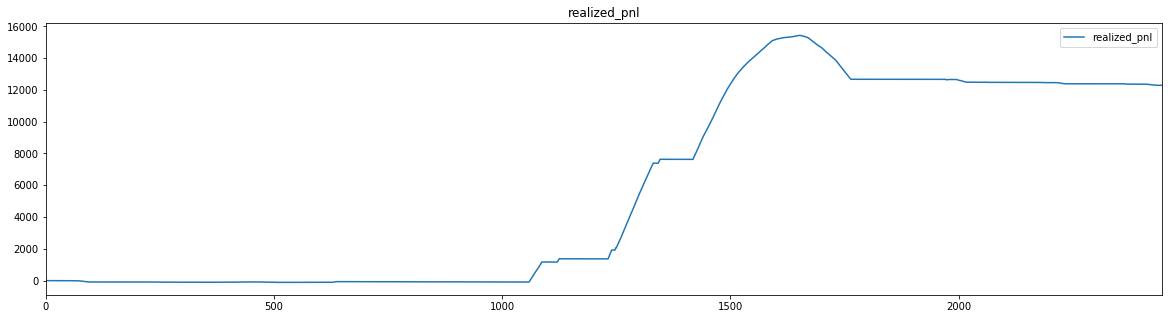

In [12]:
realized_pnl_df = pd.DataFrame(realized_pnl, columns = ["realized_pnl"])
realized_pnl_df.plot(figsize = (20,5))
plt.title("realized_pnl")
plt.show()

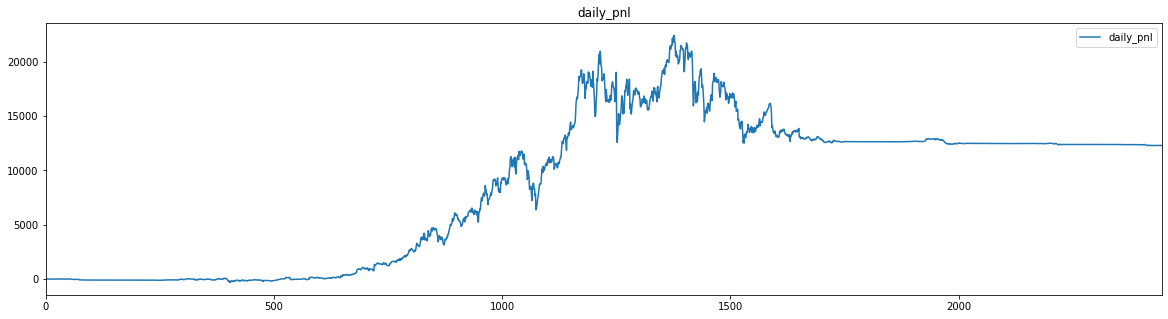

total earnings 12289.293716999788
stdev: 6645.55142870197


In [13]:
daily_pnl_df = pd.DataFrame(daily_pnl, columns = ["daily_pnl"])
daily_pnl_df.plot(figsize = (20,5))
plt.title("daily_pnl")
plt.show()
print("total earnings " + str(r_pnl))
print("stdev: " + str(statistics.stdev(daily_pnl)))

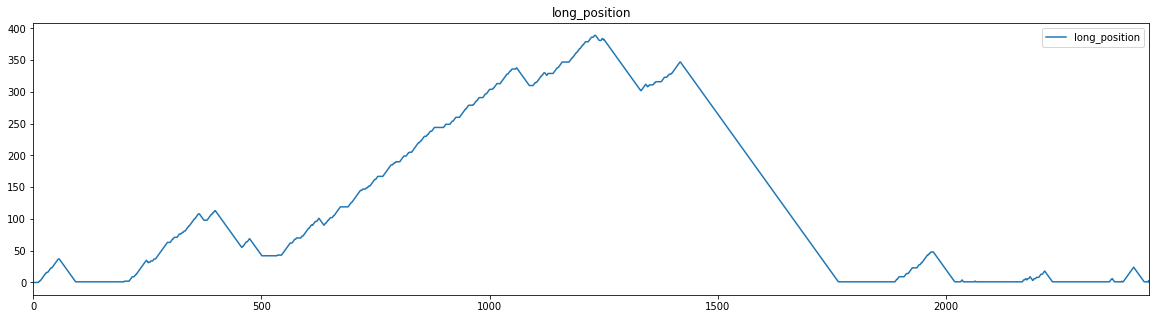

In [14]:
long_position_df = pd.DataFrame(long_position, columns = ["long_position"])
long_position_df.plot(figsize = (20,5))
plt.title("long_position")
plt.show()

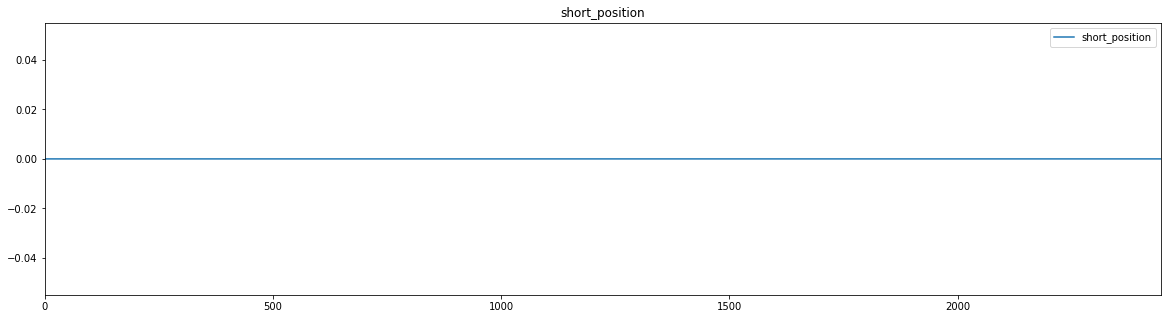

In [15]:
short_position_df = pd.DataFrame(short_position, columns = ["short_position"])
short_position_df.plot(figsize = (20,5))
plt.title("short_position")
plt.show()

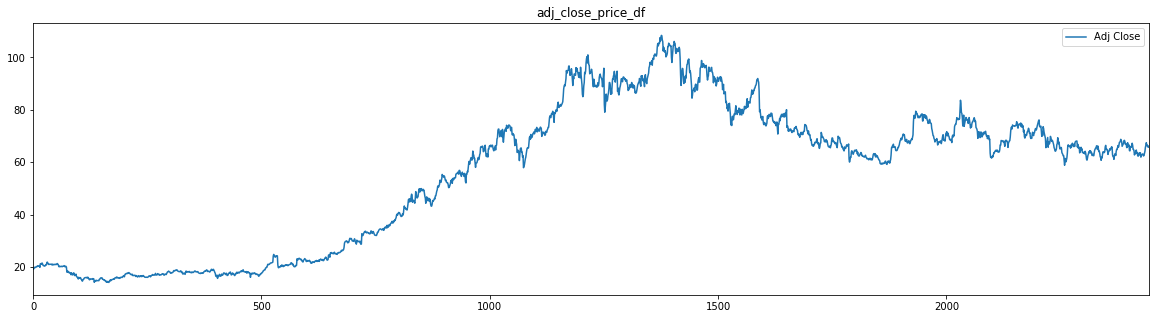

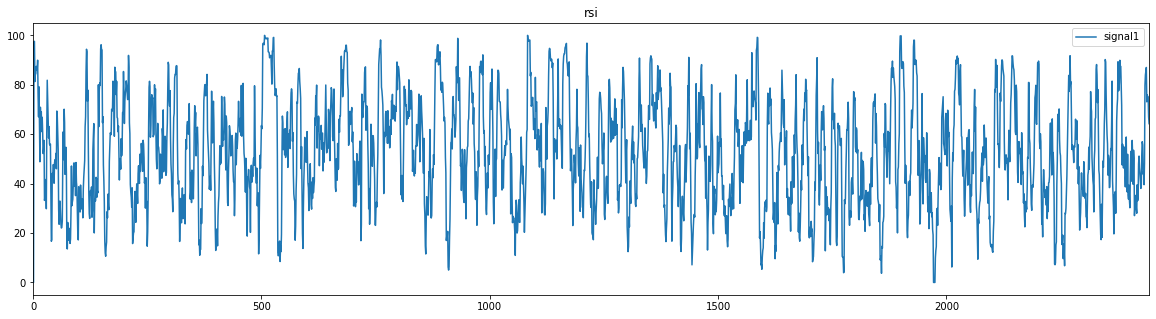

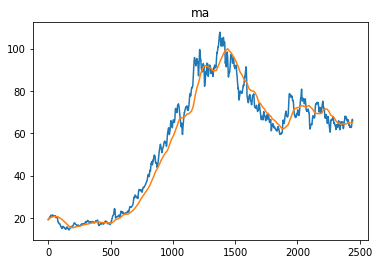

In [16]:
# Added plot for Moving Average and RSI for better planning
adj_close_price_df = pd.DataFrame(data.iloc[:,5])
adj_close_price_df.plot(figsize = (20,5))
plt.title("adj_close_price_df")
plt.show()

rsi = pd.DataFrame(signal1, columns = ["signal1"])
rsi.plot(figsize = (20,5))
plt.title("rsi")
plt.show()

mova = pd.DataFrame(signal2, columns = ["signal2"])
mova2 = pd.DataFrame(signal3, columns = ["signal3"])

plt.plot(mova)
plt.plot(mova2)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title("ma")
plt.show()
